In [243]:
from pathos.multiprocessing import ProcessPool
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from itertools import product

In [244]:
rho = 3
h = 0.00000032
m = 48
T = 1
L = 1
sigma = 3.405 #Armstrong
epsilon = 119.8 #K

In [245]:
# Example array
my_array = np.array([3, 0, 1, 4, 2, 0, 5])

# Find the index of the minimum element that is not zero
nonzero_indices = np.nonzero(my_array)  # Get indices where the elements are non-zero
min_nonzero_index = np.argmin(my_array[nonzero_indices])

# Output the result

print("Array:", my_array)
print("Nonzero indices:", nonzero_indices[0])
print("Index of the minimum non-zero element:", nonzero_indices[0][min_nonzero_index])
print("All nonzero elements:", my_array[nonzero_indices[0]])

Array: [3 0 1 4 2 0 5]
Nonzero indices: [0 2 3 4 6]
Index of the minimum non-zero element: 2
All nonzero elements: [3 1 4 2 5]


In [246]:
list_pbc = list(product([0, 1, -1], repeat=3))
list_pbc = L*np.array(list_pbc)

def f(r_i, r_j):
    #Todo: Cut potential for r_ij > sigma
    r_ij_candidates = [np.sum([(r_i[d]-r_j[d]+vec_L[d])**2 for d in range(3)]) for vec_L in list_pbc]
    index_L_min = np.argmin([r_ij_candidates])#list_pbc[index_min]
    vec_L_min = list_pbc[index_L_min]
    r_ij = np.sqrt(r_ij_candidates[index_L_min])    
    f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)+0.5*r_ij**(-8))
    return np.array([f_x, f_y, f_z])

def arange_without(i):
    original_array = np.arange(N_0)
    result_array = original_array[original_array != i]
    return result_array

def F(r):
    return np.array([np.sum(np.array([f(r[i], r[k]) for k in arange_without(i)]), axis=0) for i in range(r.shape[0])])
    #return [f(r[i], r[k]) for k in arange_without(i)] pool.map()
    #pool = ProcessPool(nodes=4)
    #results = pool.map(f_subprocess, (r for i in range(r.shape[0])), range(r.shape[0]))
    #return np.array(results)

def verlet_step(r, v):
    v_tilde = v + h/(2*m)*F(r)
    r_next = r + h*v_tilde
    f_next = F(r_next)
    v_next = v_tilde + (h/(2*m))*f_next
    return r_next, v_next

def verlet_algorithm(r_0, v_0, num_steps):
    list_r = [r_0]
    list_v = [v_0]
    for t in tqdm(range(num_steps)):
        r_new, v_new = verlet_step(list_r[-1], list_v[-1])
        list_r.append(r_new)
        list_v.append(v_new)
    return np.array(list_r), np.array(list_v)

def build_fcc(rho):
    """
    :param rho: How many points per axis of the L*L cube (minimum 2) 
    :return: fcc grid for the L*L cube (np.array of shape (n_points, 3))
    """
    #Todo: Could cause division by zero because of mirror atoms for the corner points
    range_values_sc = np.linspace(-L/2, L/2, rho)
    length_edge = np.abs(range_values_sc[0]-range_values_sc[1]) #L/(rho-1)
    sc_grid = np.array(list(product(range_values_sc, repeat=3)))
    missing_points = []
    for point in sc_grid:
        p1 = [point[0]+0.5*length_edge, point[1], point[2]+0.5*length_edge]
        p2 = [point[0]+0.5*length_edge, point[1]+0.5*length_edge, point[2]]
        p3 = [point[0], point[1]+0.5*length_edge, point[2]+0.5*length_edge]
        missing_points.append(p1)
        missing_points.append(p2)
        missing_points.append(p3)
    missing_points = np.array(missing_points)
    x = sc_grid[:,0]
    y = sc_grid[:,1]
    z = sc_grid[:,2]
    x_m = missing_points[:,0]
    y_m = missing_points[:,1]
    z_m = missing_points[:,2]
    fcc_grid = np.concatenate([sc_grid, missing_points])
    fcc_grid = fcc_grid[fcc_grid[:, 0] != -L/2]
    fcc_grid = fcc_grid[fcc_grid[:, 1] != -L/2]
    fcc_grid = fcc_grid[fcc_grid[:, 2] != -L/2]
    return fcc_grid

def Temperature(v):
    return 16*np.mean([(v_i[0]**2)+(v_i[1]**2)+(v_i[2]**2) for v_i in v])

In [247]:
r_0 = build_fcc(rho)
N_0 = r_0.shape[0]
#np.random.uniform(-L/2, L/2, (N_0, 3)) #randomly between 0 and L with gaussian distribution, mean 0, std sqrt(kT^*/m^*), m^* = 48, k = 1, are the velocities normally distributed in every seperate direction?
v_0 = np.random.normal(0,0.000001*np.sqrt(T/48), (N_0, 3))

"""
r_0: Initial positions of the system
    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle
v_0: Initial velocities of the system particles
    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle
"""


"\nr_0: Initial positions of the system\n    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle\nv_0: Initial velocities of the system particles\n    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle\n"

In [248]:
print(r_0[0])
print(r_0[1])
print([(vec_L, [(r_0[0][d]-r_0[1][d]+vec_L[d])**2 for d in range(3)]) for vec_L in list_pbc])

[0. 0. 0.]
[0.  0.  0.5]
[(array([0, 0, 0]), [0.0, 0.0, 0.25]), (array([0, 0, 1]), [0.0, 0.0, 0.25]), (array([ 0,  0, -1]), [0.0, 0.0, 2.25]), (array([0, 1, 0]), [0.0, 1.0, 0.25]), (array([0, 1, 1]), [0.0, 1.0, 0.25]), (array([ 0,  1, -1]), [0.0, 1.0, 2.25]), (array([ 0, -1,  0]), [0.0, 1.0, 0.25]), (array([ 0, -1,  1]), [0.0, 1.0, 0.25]), (array([ 0, -1, -1]), [0.0, 1.0, 2.25]), (array([1, 0, 0]), [1.0, 0.0, 0.25]), (array([1, 0, 1]), [1.0, 0.0, 0.25]), (array([ 1,  0, -1]), [1.0, 0.0, 2.25]), (array([1, 1, 0]), [1.0, 1.0, 0.25]), (array([1, 1, 1]), [1.0, 1.0, 0.25]), (array([ 1,  1, -1]), [1.0, 1.0, 2.25]), (array([ 1, -1,  0]), [1.0, 1.0, 0.25]), (array([ 1, -1,  1]), [1.0, 1.0, 0.25]), (array([ 1, -1, -1]), [1.0, 1.0, 2.25]), (array([-1,  0,  0]), [1.0, 0.0, 0.25]), (array([-1,  0,  1]), [1.0, 0.0, 0.25]), (array([-1,  0, -1]), [1.0, 0.0, 2.25]), (array([-1,  1,  0]), [1.0, 1.0, 0.25]), (array([-1,  1,  1]), [1.0, 1.0, 0.25]), (array([-1,  1, -1]), [1.0, 1.0, 2.25]), (array([-1, -1

In [257]:
f(r_0[9], r_0[2])

array([-11810.41426612,  11810.41426612,  23620.82853224])

In [255]:
F(r_0)

C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:10: RuntimeWarning: divide by zero encountered in scalar power
  f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:11: RuntimeWarning: divide by zero encountered in scalar power
  f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:12: RuntimeWarning: divide by zero encountered in scalar power
  f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppDat

array([[ 1.50597641e+08,  1.50597641e+08,  1.50597641e+08],
       [ 1.50597641e+08,  1.50597641e+08, -1.50597641e+08],
       [ 1.50597641e+08, -1.50597641e+08,  1.50597641e+08],
       [ 1.50597641e+08, -1.50597641e+08, -1.50597641e+08],
       [-1.50597641e+08,  1.50597641e+08,  1.50597641e+08],
       [-1.50597641e+08,  1.50597641e+08, -1.50597641e+08],
       [-1.50597641e+08, -1.50597641e+08,  1.50597641e+08],
       [-1.50597641e+08, -1.50597641e+08, -1.50597641e+08],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [            nan,             nan

Text(0.5, 0.92, 'Initial state of the Argon ')

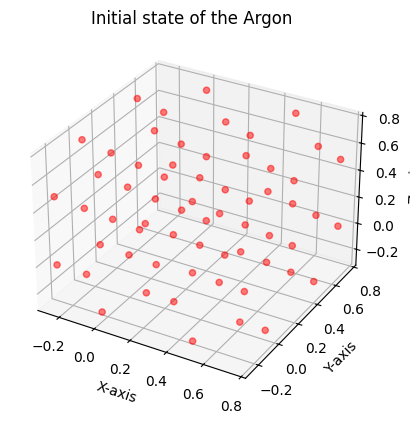

In [250]:
#Seeing how the initial state looks like
#ax = plt.figure().add_subplot(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Extract x, y, and z coordinates
x = r_0[:,0].flatten()
y = r_0[:,1].flatten()
z = r_0[:,2].flatten()

# Plot the points
ax.scatter(x, y, z, c='r', marker='o', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()

In [251]:
t_max = 10
r_total, v_total = verlet_algorithm(r_0, v_0, t_max)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:10: RuntimeWarning: divide by zero encountered in scalar power
  f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:11: RuntimeWarning: divide by zero encountered in scalar power
  f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:12: RuntimeWarning: divide by zero encountered in scalar power
  f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)

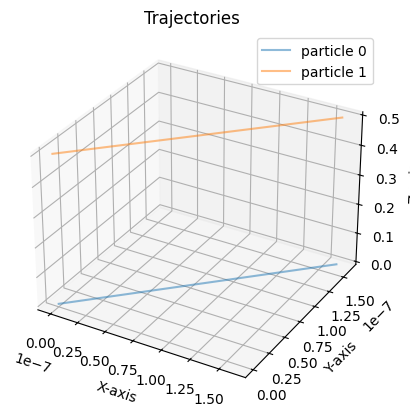

In [252]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(r_total[:,0,0], r_total[:,0,1], r_total[:,0,2], alpha=0.5, label= "particle 0")
ax.plot(r_total[:,1,0], r_total[:,1,1], r_total[:,1,2], alpha=0.5, label= "particle 1")

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectories ')
plt.legend()

Text(0.5, 1.0, 'Temperature over time')

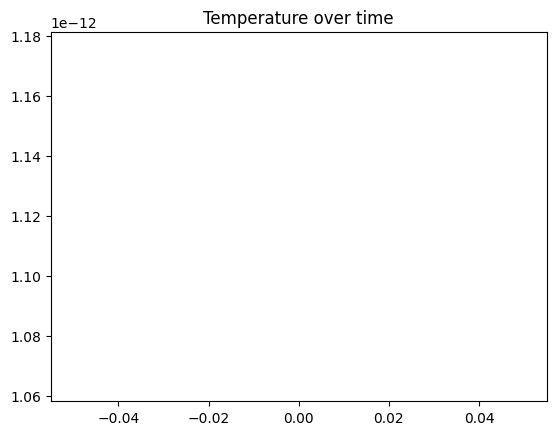

In [253]:
T_total = [Temperature(v_t) for v_t in v_total]
plt.plot(np.arange(t_max+1), T_total)
plt.title("Temperature over time")

C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:10: RuntimeWarning: divide by zero encountered in scalar power
  f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:11: RuntimeWarning: divide by zero encountered in scalar power
  f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_26972\2158898506.py:12: RuntimeWarning: divide by zero encountered in scalar power
  f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppDat

Text(0.5, 1.0, 'Force that acts on particle 0 in x-direction over time')

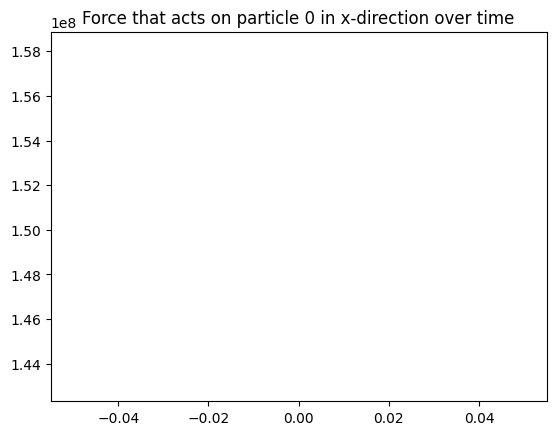

In [254]:
plt.plot(np.arange(t_max+1), [F(r_total[t])[0,0] for t in range(t_max+1)])
plt.title("Force that acts on particle 0 in x-direction over time")